### Step 1: Import Libraries and Define Connection Parameters

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sqlalchemy import create_engine, MetaData
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# Database connection parameters
db_params = {
    'host': '194.171.191.226',
    'port': '6379',
    'database': 'postgres',
    'user': 'group17',
    'password': 'blockd_2024group17_61'
}

def get_connection():
    """Establish and return a new database connection."""
    return psycopg2.connect(**db_params)

---

### Step 2: Load Data

In [3]:
def load_data():
    conn = get_connection()
    query = "SELECT * FROM data_lake.safe_driving;"
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

df = load_data()


/tmp/ipykernel_2518632/679495544.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


---

### Step 3: Identifying Duplicates in the DataFrame

In [4]:
def check_duplicates(df):
    dupes = df.duplicated()
    print(f"Duplicates: {dupes.sum()}")

# Call the function to check for duplicates
check_duplicates(df)

Duplicates: 0


---

### Step 4: Analyzing Missing Values Across Columns

In [5]:
def report_missing_values(df):
    missing_vals = df.isnull().sum()
    print(f"Missing Values:\n{missing_vals}")

# Call the function to report missing values
report_missing_values(df)

Missing Values:
eventid              0
event_start          0
event_end            0
duration_seconds     0
latitude             0
longitude            0
speed_kmh            0
end_speed_kmh        0
maxwaarde            0
category             0
incident_severity    0
is_valid             0
road_segment_id      0
road_manager_type    0
road_number          0
road_name            0
place_name           0
municipality_name    0
road_manager_name    0
dtype: int64


---

### Step 5: Removing unnecessary columns

In [6]:
def remove_unnecessary_columns(df):
    """
    Safely removes specified columns from the DataFrame, checking if they exist first.
    :param df: DataFrame from which to remove columns.
    :return: DataFrame with specified columns removed if they exist.
    """
    columns_to_remove = [
        'eventid', 'road_segment_id', 'road_manager_type', 'road_number', 
        'place_name', 'municipality_name', 'road_manager_name'
    ]
    # Ensure only columns that exist in the DataFrame are attempted to be removed
    columns_to_remove = [col for col in columns_to_remove if col in df.columns]
    df.drop(columns_to_remove, axis=1, inplace=True)
    return df

# Apply the function to remove the columns, assuming df is your DataFrame loaded with your dataset
df = remove_unnecessary_columns(df)
print("Updated DataFrame after removing specified columns:")
print(df.head())


Updated DataFrame after removing specified columns:
              event_start               event_end  duration_seconds  latitude  \
0 2020-08-25 17:53:33.500 2020-08-25 17:53:40.500               7.0  51.57719   
1 2020-08-25 07:52:13.300 2020-08-25 07:52:14.200               0.9  51.61198   
2 2020-08-25 15:28:20.000 2020-08-25 15:28:29.000               9.0  51.57710   
3 2020-08-25 15:59:00.400 2020-08-25 15:59:02.200               1.8  51.60271   
4 2020-08-25 17:04:34.000 2020-08-25 17:04:35.100               1.1  51.59393   

   longitude  speed_kmh  end_speed_kmh  maxwaarde          category  \
0   4.795964  65.983100      65.983100  65.983100  SPEED              
1   4.774075  45.061630      11.265408   1.181259  BRAKING            
2   4.795340  62.542904      66.394910  66.477715  SPEED              
3   4.729070  28.968191      28.968191   0.778922  HARSH CORNERING    
4   4.822312  49.889664      49.889664   0.703283  HARSH CORNERING    

  incident_severity  is_valid     

In [7]:
print("Current columns in DataFrame:", df.columns.tolist())


Current columns in DataFrame: ['event_start', 'event_end', 'duration_seconds', 'latitude', 'longitude', 'speed_kmh', 'end_speed_kmh', 'maxwaarde', 'category', 'incident_severity', 'is_valid', 'road_name']


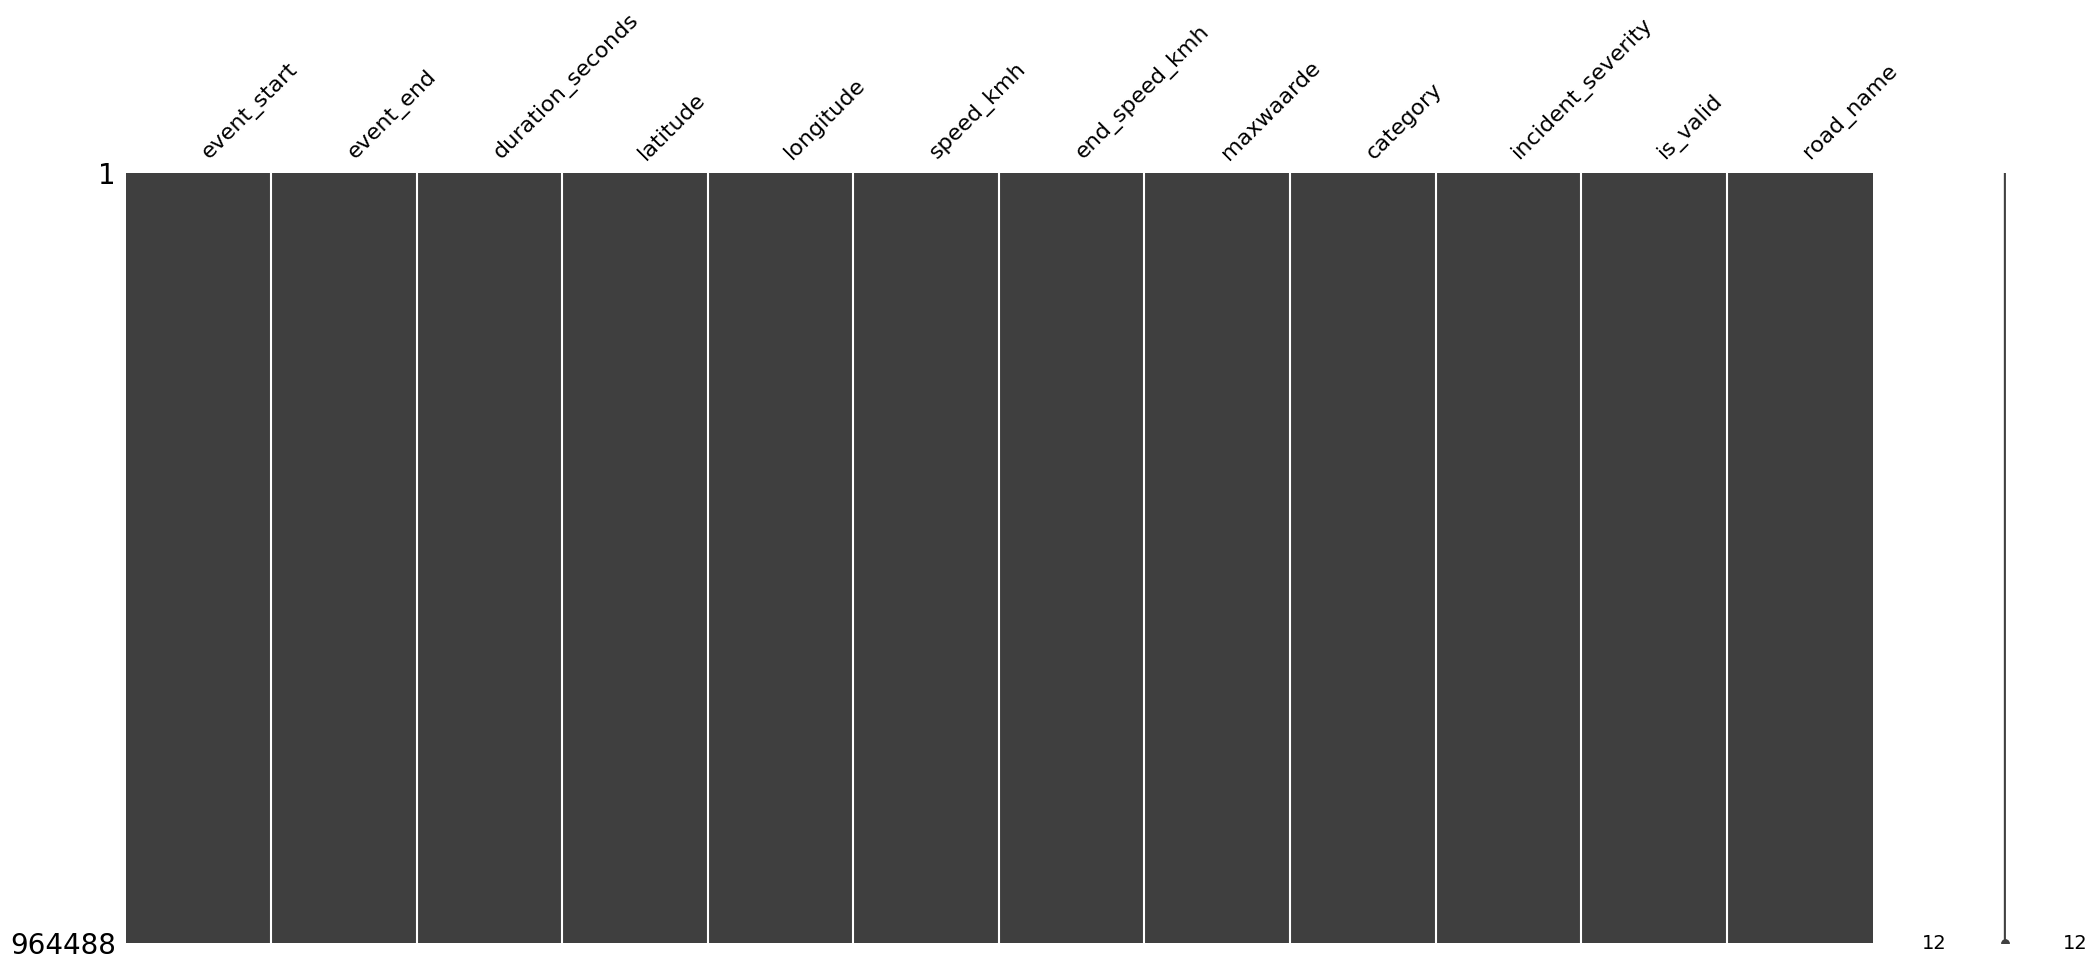

In [8]:
import missingno as msno
msno.matrix(df)
plt.show()

---

### Step 6: Visual Identification of Outliers

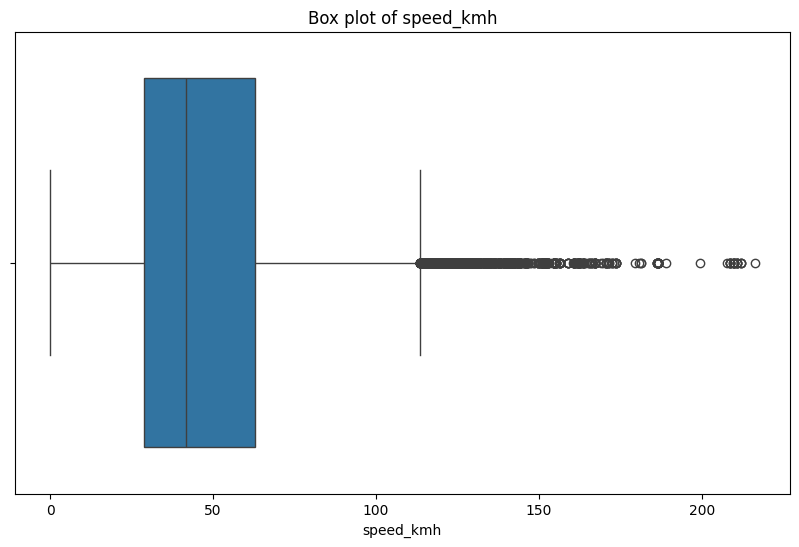

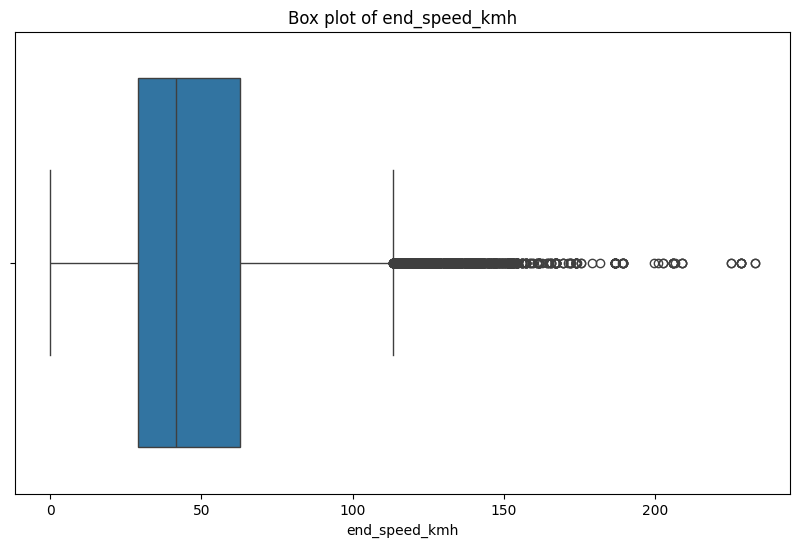

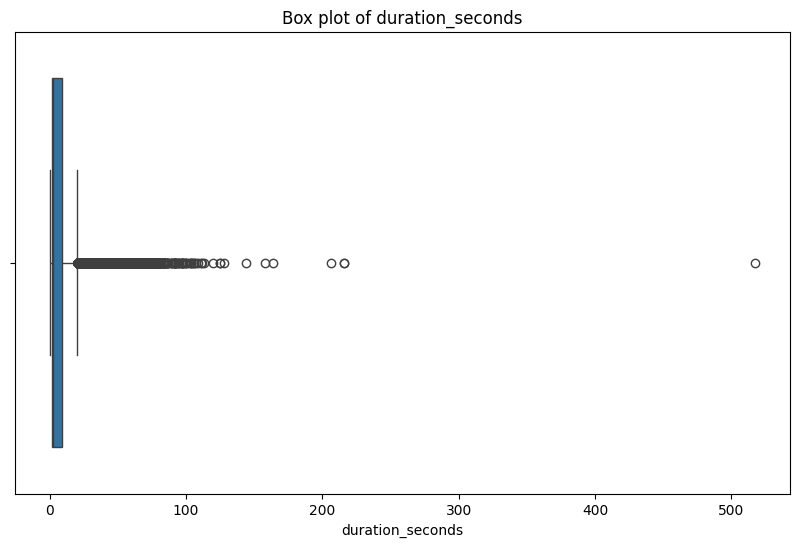

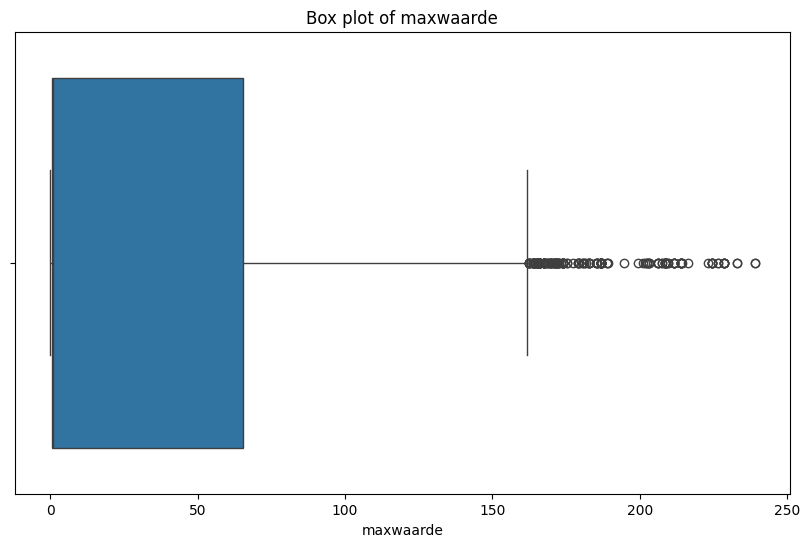

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical columns to check for outliers
numerical_columns = ['speed_kmh', 'end_speed_kmh', 'duration_seconds', 'maxwaarde']

# Create box plots for each numerical column
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Box plot of {column}')
    plt.show()

---

### Step 7: Handling the Outliers 

In many datasets that follow a normal distribution:<br>

- Approximately 68% of the data points have a z-score between -1 and 1.
- Approximately 95% of the data points have a z-score between -2 and 2.
- Approximately 99.7% of the data points have a z-score between -3 and 3.
- Thus, a z-score beyond ±3 is considered rare and often flagged as an outlier 

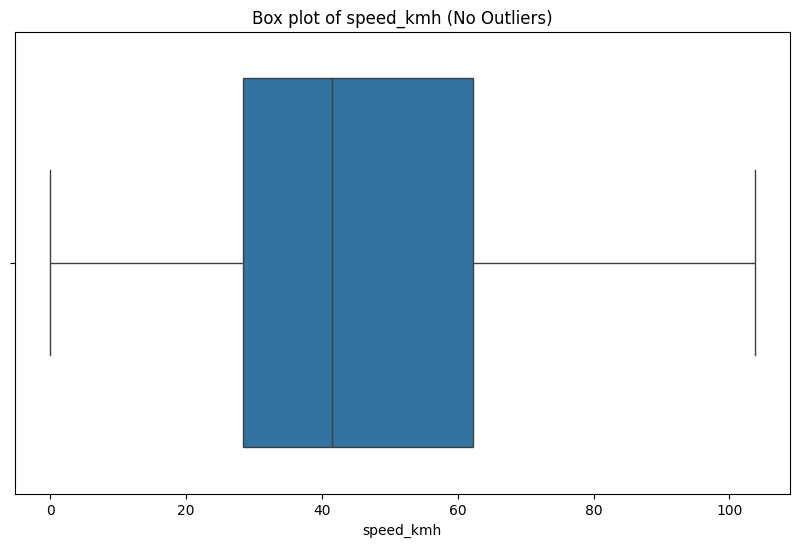

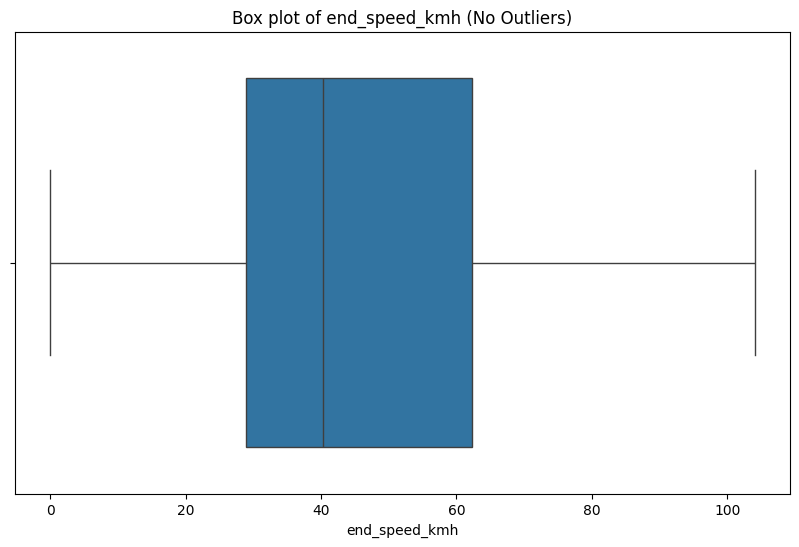

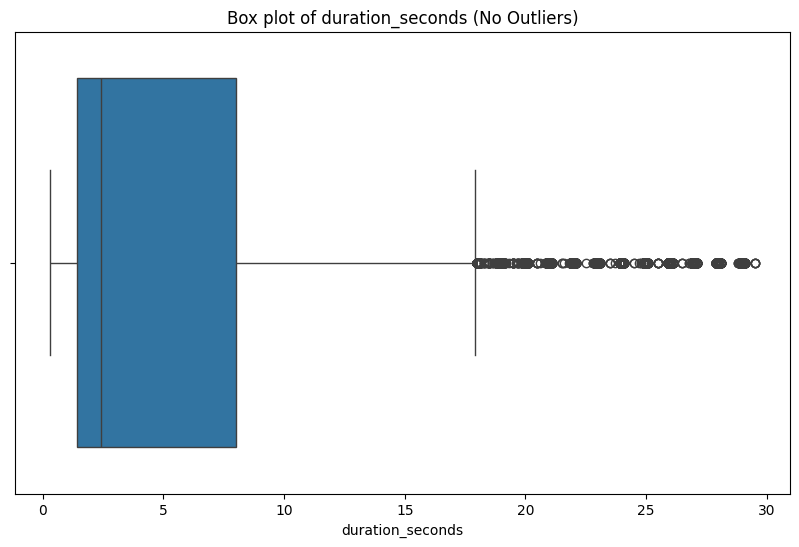

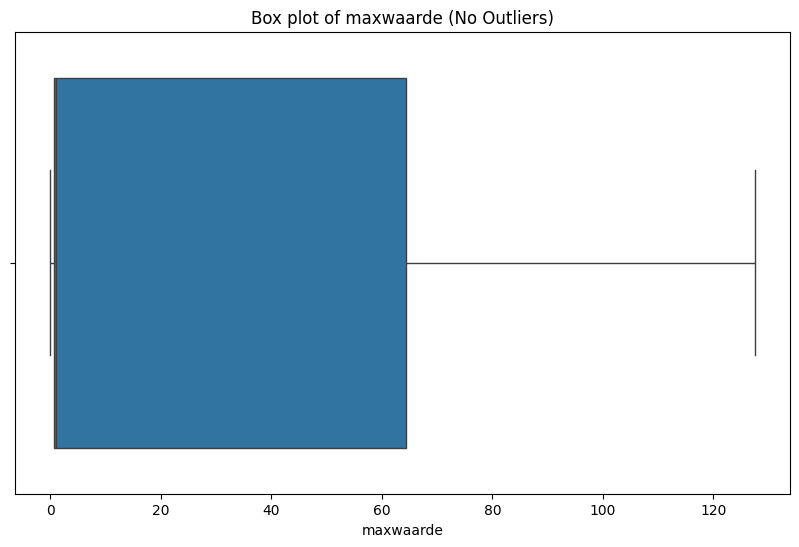

In [10]:
# Maybe we will need to see what outliers are relavant to keep in our dataset, for now I keeped duration_seconds as is bellow
numerical_columns = ['speed_kmh', 'end_speed_kmh', 'duration_seconds', 'maxwaarde']

# Calculate z-scores for each numerical column
z_scores = np.abs(stats.zscore(df[numerical_columns]))

# Set a threshold for identifying outliers (
threshold = 3

# Remove rows with outliers
df_no_outliers = df[(z_scores < threshold).all(axis=1)]

for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_no_outliers[column])
    plt.title(f'Box plot of {column} (No Outliers)')
    plt.show()

---

### Step 8: Joining the datasets 

In [11]:
# Connect using the parameters
conn_psycopg2 = psycopg2.connect(**db_params)

# Create cursor object
cursor = conn_psycopg2.cursor()

def execute_sql(query):
    try:
        cursor.execute(query)
        conn_psycopg2.commit()
    except psycopg2.Error as e:
        print(f"An error occurred: {e}")
        conn_psycopg2.rollback()

In [12]:
# SQL script for managing weather classification with CASCADE to handle dependencies
sql_script = """
-- Drop existing tables if they exist, using CASCADE to drop any dependent objects
DROP TABLE IF EXISTS group17_warehouse.temperature_modified CASCADE;
DROP TABLE IF EXISTS group17_warehouse.precipitation_modified CASCADE;
DROP TABLE IF EXISTS group17_warehouse.final_modified_temp CASCADE;

-- Create temperature_modified table from data_lake.wind
CREATE TABLE group17_warehouse.temperature_modified AS
SELECT 
    DATE(dtg) AS dtg, 
    AVG(FF_SENSOR_10 * 3.6) AS wind_speed_kmph
FROM data_lake.wind
GROUP BY 1;

-- Create precipitation_modified table from data_lake.precipitation
CREATE TABLE group17_warehouse.precipitation_modified AS
SELECT 
    DATE(dtg) AS dtg,
    AVG(dr_pws_10) AS precipitation_secs
FROM data_lake.precipitation
GROUP BY 1;

-- Create final_modified_temp table integrating weather conditions
CREATE TABLE group17_warehouse.final_modified_temp AS
SELECT 
    DATE(sd.event_start) AS event_date, 
    temp.wind_speed_kmph,
    prec.precipitation_secs,
    sd.eventid,
    CASE
        WHEN prec.precipitation_secs > 500 THEN 'Rainy'
        WHEN temp.wind_speed_kmph > 20 THEN 'Windy'
        WHEN prec.precipitation_secs <= 500 AND temp.wind_speed_kmph <= 20 THEN 'Sunny'
        ELSE 'Undefined'
    END AS weather_condition
FROM data_lake.safe_driving sd
LEFT JOIN group17_warehouse.temperature_modified temp ON DATE(sd.event_start) = temp.dtg
LEFT JOIN group17_warehouse.precipitation_modified prec ON DATE(sd.event_start) = prec.dtg
GROUP BY 1, 2, 3, 4, 5;
"""

# Execute the SQL script
try:
    cursor.execute(sql_script)
    conn_psycopg2.commit()
    print("Weather classification tables successfully updated.")
except psycopg2.Error as e:
    conn_psycopg2.rollback()
    print(f"An error occurred: {e}")


Weather classification tables successfully updated.


---

### Step 9: Creating views

In [13]:
# List of SQL statements to create views
create_view_statements = [
    """
    CREATE OR REPLACE VIEW group17_warehouse.vw_temperature AS
    SELECT 
        dtg AS date, 
        wind_speed_kmph AS wind_speed_in_kmph
    FROM 
        group17_warehouse.temperature_modified;
    """,
    """
    CREATE OR REPLACE VIEW group17_warehouse.vw_precipitation AS
    SELECT 
        dtg AS date, 
        precipitation_secs AS precipitation_in_seconds
    FROM 
        group17_warehouse.precipitation_modified;
    """,
    """
    CREATE OR REPLACE VIEW group17_warehouse.vw_weather_conditions AS
    SELECT 
        event_date, 
        wind_speed_kmph, 
        precipitation_secs,
        weather_condition
    FROM 
        group17_warehouse.final_modified_temp;
    """
]

In [14]:
# Execute each CREATE VIEW statement
for statement in create_view_statements:
    try:
        cursor.execute(statement)
        conn_psycopg2.commit()  # Commit changes after each execution
    except psycopg2.Error as e:
        print(f"An error occurred: {e}")
        conn_psycopg2.rollback()  # Rollback on error

---

### Step 10: Re-establishing the cursor and fetching data

In [15]:
import pandas as pd

# Re-establishing the cursor
cursor = conn_psycopg2.cursor()

# SQL to fetch data from the view
query = "SELECT * FROM group17_warehouse.vw_weather_conditions;"

try:
    cursor.execute(query)
    # Fetch the results
    data = cursor.fetchall()
    # Extract column names from the cursor description
    columns = [desc[0] for desc in cursor.description]
    # Create a DataFrame to display the data neatly
    df = pd.DataFrame(data, columns=columns)
    print(df)
except psycopg2.Error as e:
    print(f"An error occurred while fetching data: {e}")
finally:
    cursor.close()


        event_date  wind_speed_kmph  precipitation_secs weather_condition
0       2018-01-01         28.42775          189.250000             Windy
1       2018-01-01         28.42775          189.250000             Windy
2       2018-01-01         28.42775          189.250000             Windy
3       2018-01-01         28.42775          189.250000             Windy
4       2018-01-01         28.42775          189.250000             Windy
...            ...              ...                 ...               ...
964033  2024-02-29         27.89250          249.833333             Windy
964034  2024-02-29         27.89250          249.833333             Windy
964035  2024-02-29         27.89250          249.833333             Windy
964036  2024-02-29         27.89250          249.833333             Windy
964037  2024-02-29         27.89250          249.833333             Windy

[964038 rows x 4 columns]


---

### Step 11:  Visualizing Weather Condition Distribution.

In [16]:
# Display count of each weather condition
condition_counts = df['weather_condition'].value_counts()
print(condition_counts)


weather_condition
Sunny        545630
Windy        391496
Undefined     25931
Rainy           981
Name: count, dtype: int64


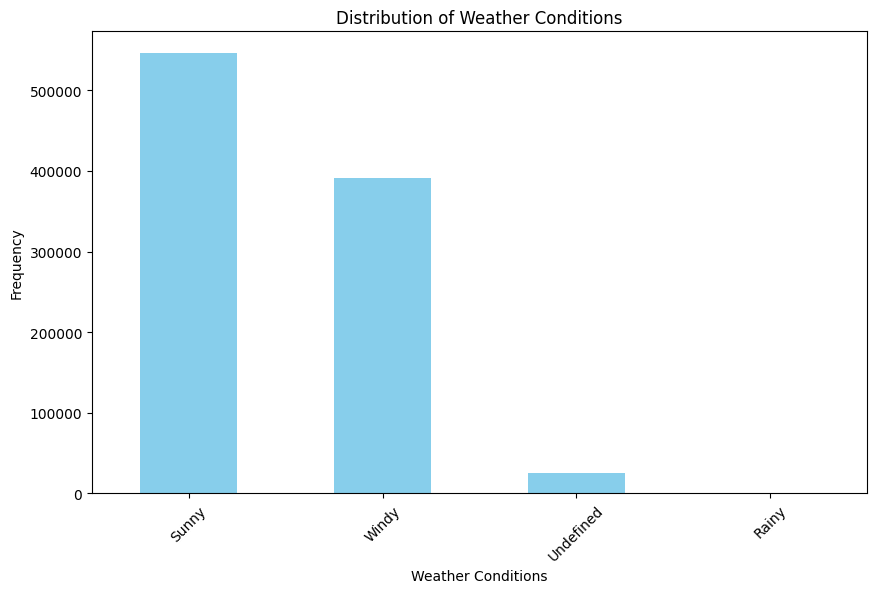

In [17]:
import matplotlib.pyplot as plt

# Plotting the distribution of weather conditions
plt.figure(figsize=(10, 6))
df['weather_condition'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Weather Conditions')
plt.xlabel('Weather Conditions')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

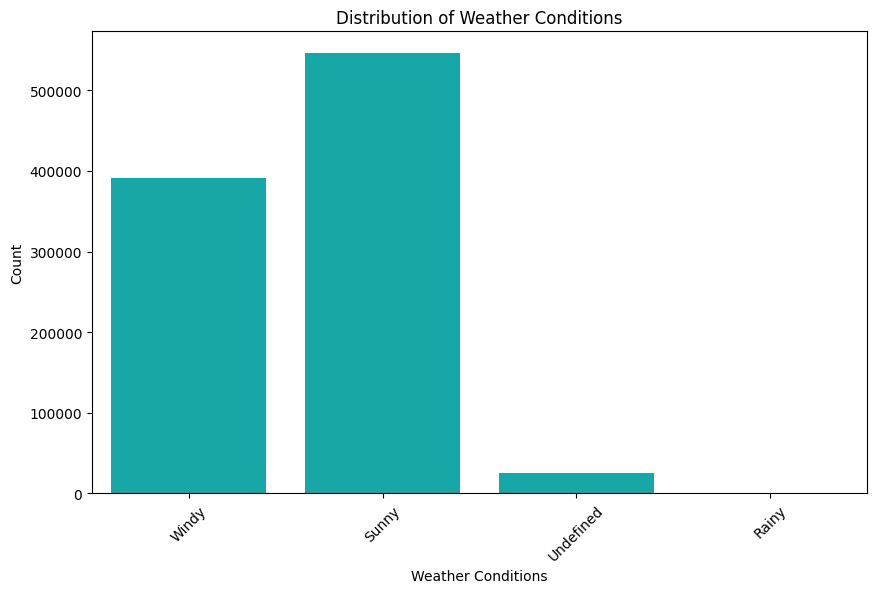

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Using seaborn to plot the same data without deprecated usage
plt.figure(figsize=(10, 6))
sns.countplot(x='weather_condition', data=df, color='c')  # Using a single color
plt.title('Distribution of Weather Conditions')
plt.xlabel('Weather Conditions')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [19]:
# Print all column names in the DataFrame
print(df.columns)


Index(['event_date', 'wind_speed_kmph', 'precipitation_secs',
       'weather_condition'],
      dtype='object')


---

### Step 12: Separating feature and target variables and splitting data

In [20]:
# Separating features and target variable
X = df.drop('weather_condition', axis=1)  # All other columns as features
y = df['weather_condition']  # Target variable

X = pd.get_dummies(X)

# Optionally, split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---

### Step 13: Scaling Features

In [21]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
features_to_scale = ['wind_speed_kmph', 'precipitation_secs']

# Check variance and apply scaling
for feature in features_to_scale:
    if df[feature].std() > 0:
        df[feature] = scaler.fit_transform(df[[feature]])
    else:
        print(f"No variance in {feature}")

# Display the scaled data and statistics
print(df.head())
print(df[features_to_scale].describe())



   event_date  wind_speed_kmph  precipitation_secs weather_condition
0  2018-01-01         0.971382             2.66135             Windy
1  2018-01-01         0.971382             2.66135             Windy
2  2018-01-01         0.971382             2.66135             Windy
3  2018-01-01         0.971382             2.66135             Windy
4  2018-01-01         0.971382             2.66135             Windy
       wind_speed_kmph  precipitation_secs
count    938433.000000       953221.000000
mean          0.141564            0.576233
std           0.808346            1.129412
min          -1.387075           -0.125153
25%          -0.429531           -0.125153
50%           0.000000            0.000000
75%           0.570469            0.874847
max           4.108071            7.280982


---

### Step 14: Plotting Histogram for Scaled Features

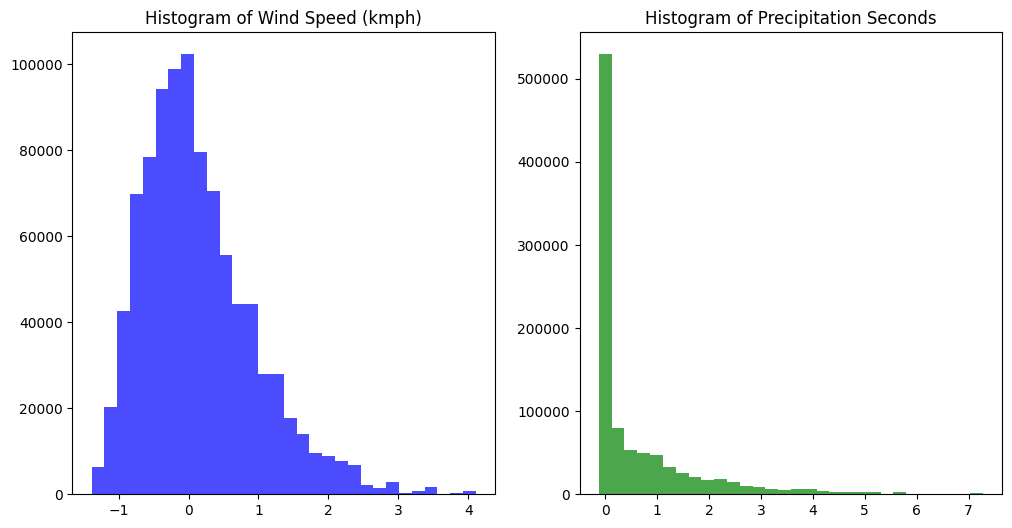

In [22]:
import matplotlib.pyplot as plt

# Histogram for wind_speed_kmph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['wind_speed_kmph'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Wind Speed (kmph)')

# Histogram for precipitation_secs
plt.subplot(1, 2, 2)
plt.hist(df['precipitation_secs'], bins=30, color='green', alpha=0.7)
plt.title('Histogram of Precipitation Seconds')

plt.show()


---

###  Step 15: Implementing Random Sampling with Replacement

In [23]:
import numpy as np

# Assuming 'weather_condition' is the target column in df
y = df['weather_condition']
X = df.drop('weather_condition', axis=1)  # This assumes other columns are features

# Calculate the size to match - typically the size of the smallest class
target_size = y.value_counts().min()

# Create a new DataFrame for the balanced data
balanced_df = pd.DataFrame()

# Iterate over each class
for condition in y.unique():
    subset = df[df['weather_condition'] == condition]
    
    # Resample if necessary
    if len(subset) > target_size:
        resampled = subset.sample(n=target_size, replace=True, random_state=42)
    else:
        resampled = subset
    
    # Append to the balanced DataFrame
    balanced_df = pd.concat([balanced_df, resampled], axis=0)


# Verify the class distribution
print(balanced_df['weather_condition'].value_counts())


weather_condition
Windy        981
Sunny        981
Undefined    981
Rainy        981
Name: count, dtype: int64


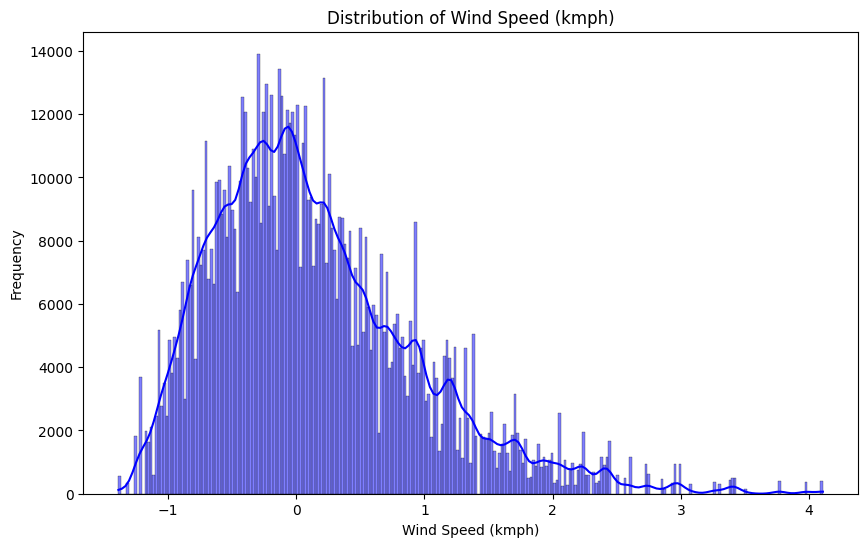

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#'wind_speed_kmph' is a continuous feature that we will be using
plt.figure(figsize=(10, 6))
sns.histplot(df['wind_speed_kmph'], kde=True, color='blue')
plt.title('Distribution of Wind Speed (kmph)')
plt.xlabel('Wind Speed (kmph)')
plt.ylabel('Frequency')
plt.show()


In [25]:
skewness = df['wind_speed_kmph'].skew()
print(f"Skewness of wind speed: {skewness}")

Skewness of wind speed: 1.0086798104026293


---

### Step 16: Implementing Log Transformation

In [29]:
# Shift data to ensure all values are positive
shift = 1 - df['wind_speed_kmph'].min()  
df['shifted_wind_speed'] = df['wind_speed_kmph'] + shift

# Verify no zero or negative values remain
print("Minimum value after shift:", df['shifted_wind_speed'].min())

Minimum value after shift: 1.0


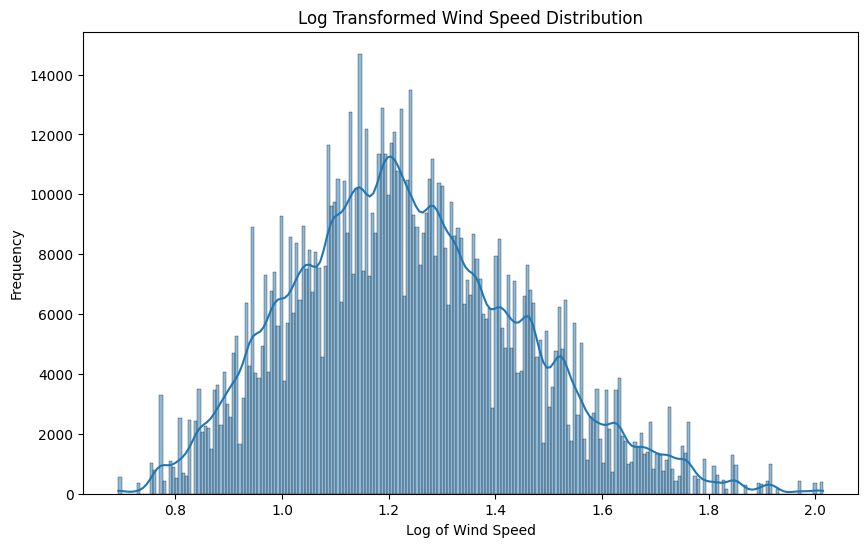

Skewness after log transformation: 0.3719794321076721


In [30]:
# Log transformation (log1p for handling zero after minimal shift)
df['log_wind_speed'] = np.log1p(df['shifted_wind_speed'])

# Plot to see the effect
plt.figure(figsize=(10, 6))
sns.histplot(df['log_wind_speed'], kde=True)
plt.title('Log Transformed Wind Speed Distribution')
plt.xlabel('Log of Wind Speed')
plt.ylabel('Frequency')
plt.show()

# Calculate new skewness
print("Skewness after log transformation:", df['log_wind_speed'].skew())


### Conclusion: 
The skewness value of 0.3719794321076721 after applying the log transformation indicates a significant improvement towards achieving a normal-like distribution of your wind speed data. This skewness level is quite close to zero, which is ideal for many statistical models that assume normality, particularly linear regression model. 